<a href="https://colab.research.google.com/github/Prab999/CSCI167/blob/main/project/Project167_CIFARCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
#Followed similar format as notebook 10.5
#Normalize
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std  = (0.2470, 0.2435, 0.2616)
#Transform + Dataset
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),         # 50% chance to flip image
    transforms.RandomCrop(32, padding=4),      # crop with padding
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

#training transformations, data augmentation, random crop, converting
#to pytorch tensor, normalize
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

batch_size = 128
#downloading and creating proper sets
train_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=train_transform,
)

In [ ]:
#Using offical CIFAR10 test set as validation
val_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=val_transform,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)
print("Train size:", len(train_dataset), "Val size:", len(val_dataset))

Train size: 50000 Val size: 10000


In [ ]:
class ConvNet_CIFAR10(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolution layers, 3 in, 32 out, 5 kernelsize 5x5 receptive field
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(32)  #Batch normalizaiton normalizes each feature map accross batch

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(64)

        self.drop = nn.Identity()      # Testing related

        # flatten 1600 vector per image
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Block 1: conv, batch norm, reLu, maxpool
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        # Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.drop(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        # Flatten
        x = x.flatten(1)

        # Fully connected head
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x


In [ ]:
#Optimizer, loss, and model. using l2 regularization
model = ConvNet_CIFAR10().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=5e-4
)

In [ ]:
import math
from time import time
#per training epoch, reset gradients, forward pass, cross entropy loss
#backward pass, accumulate loss and predictions
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            running_correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_correct / total
    return epoch_loss, epoch_acc

In [ ]:
#training loop storing for plots
num_epochs = 10

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    val_loss, val_acc = evaluate(
        model, val_loader, criterion, device
    )
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )

Epoch 01 | Train Loss: 0.7798, Train Acc: 0.7265 | Val Loss: 0.7675, Val Acc: 0.7286
Epoch 02 | Train Loss: 0.7632, Train Acc: 0.7307 | Val Loss: 0.7069, Val Acc: 0.7552
Epoch 03 | Train Loss: 0.7509, Train Acc: 0.7364 | Val Loss: 0.7018, Val Acc: 0.7568
Epoch 04 | Train Loss: 0.7474, Train Acc: 0.7387 | Val Loss: 0.7274, Val Acc: 0.7429
Epoch 05 | Train Loss: 0.7313, Train Acc: 0.7455 | Val Loss: 0.7056, Val Acc: 0.7521
Epoch 06 | Train Loss: 0.7196, Train Acc: 0.7505 | Val Loss: 0.7069, Val Acc: 0.7532
Epoch 07 | Train Loss: 0.7177, Train Acc: 0.7497 | Val Loss: 0.7025, Val Acc: 0.7575
Epoch 08 | Train Loss: 0.7063, Train Acc: 0.7525 | Val Loss: 0.6443, Val Acc: 0.7769
Epoch 09 | Train Loss: 0.7002, Train Acc: 0.7569 | Val Loss: 0.6800, Val Acc: 0.7649
Epoch 10 | Train Loss: 0.6900, Train Acc: 0.7618 | Val Loss: 0.7167, Val Acc: 0.7493


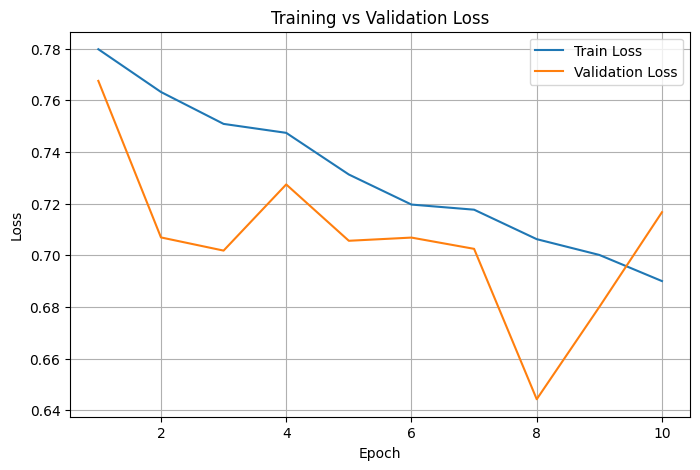

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

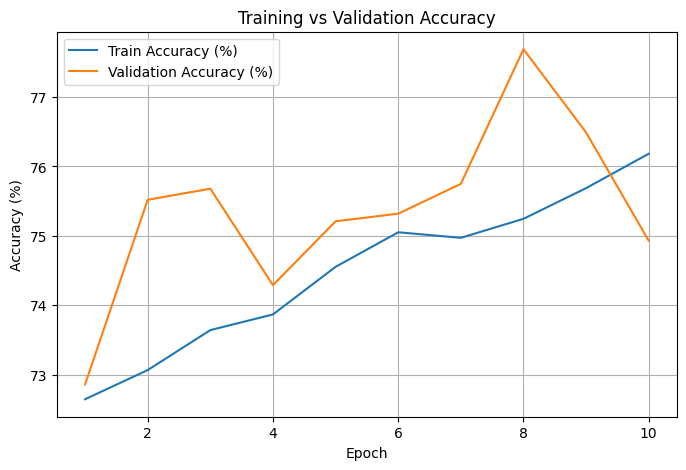

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(epochs, [a*100 for a in train_accuracies], label="Train Accuracy (%)")
plt.plot(epochs, [a*100 for a in val_accuracies], label="Validation Accuracy (%)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()